# Prepare the environment
Setup the matplotlib environment to look pretty.

In [1]:
import matplotlib.pyplot
from mpl_toolkits.mplot3d import Axes3D
# Show the plots inside the notebook.
%matplotlib inline
# Make the figures high-resolution.
%config InlineBackend.figure_format='retina'
# Various font sizes.
ticksFontSize=18
labelsFontSizeSmall=20
labelsFontSize=30
titleFontSize=34
legendFontSize=14
matplotlib.rc('xtick', labelsize=ticksFontSize) 
matplotlib.rc('ytick', labelsize=ticksFontSize)
# Colourmaps.
cm=matplotlib.pyplot.cm.get_cmap('viridis')

Other imports.

In [2]:
import statsmodels.api as sm
import numpy, scipy.interpolate

# Introduction

Find settings of the LOWESS smoothing that reduce the erros when smoothing the time series of mean motion, $n$ of a given object. In order to do this, split the TLE time series into test and training subsets. First, smoothen the training subset and compute the errors w.r.t. test subset for some LOWESS settings. Rinse and repeat with different test and training subsets for the same settings. Then change the settings and repeat. At the end, choose the settings that minimised the error and post-optimise them numerically. Investigate the 2nd derivative of mean motion w.r.t. time, $\ddot{n}$, to make sure that the fitlering result is smooth, i.e. achieves its purpose. The required steps are:

1.  Load TLE orbital elements.
2.  Filter out corrected TLEs.
3.  Loop over pre-defined LOWESS settings:
    1. Loop over a pre-defined number of test and training subsets (different test cases):
        1. Smoothen the training subset with the current settings,
        2. Compute the difference between test and smoohten training subset.
4. For every test-training subset, numerically post-optimise the best settings found in point 3.
5. Check how the optimised results compare to the fitler settings investigated in point 3.
6. Check $\ddot{n}$ of the optimised results to ensure they result in a smooth time series.
7. Choose the optimised settings with the lowest 2-norm of the difference between the smoothed traning and test subsets.

## Script controls

Choose the whether to automatically save figures besides showing them, save the raw data, and which object to analyse.

In [3]:
SSC=13025 # Will work with this object

# Load TLEs

Do not parse the TLEs because that requires a parser function, which forms a part of the proprietary ESA code. Load already parsed elements extracted from the TLEs.

In [4]:
meanMotions=numpy.load('{}MeanMotions.npy'.format(SSC))
epochsJD=numpy.load('{}epochsJD.npy'.format(SSC),)
epochs=numpy.load('{}epochs.npy'.format(SSC))
print("Read {} TLEs for {}.".format(meanMotions.size,SSC))

Read 2224 TLEs for 13025.


# Pre-process the TLEs

Need to remove corrected TLEs from the time series, they will make resampling produce dodgy results.

In the case of `13025` object, also remove the last TLE - it would be marked as an epoch outlier by `findNAndTOutliersAndSeqeunces` but we won't be running the filters here, so need to remove that TLE manually.

The function to fitler corrected TLEs forms part of a proprietary code. However, its resuls for `13025` have been saved to `npy` files to allow the results to be reproduced. `outlierFlags` equal to 1 correspond to TLEs that are followed by another TLE published less than half an orbital period later, i.e. are believed to have been corrected.

In [5]:
# Identify the TLEs that have been corrected, i.e.
# preceed the next one by less than 0.5 orbital period.
# Filtering code not included.
outlierFlags=numpy.load('{}outlierFlags.npy'.format(SSC))
sequenceIDs=numpy.load('{}sequenceIDs.npy'.format(SSC))
print("Found {} corrected TLEs.".format(numpy.sum(
      outlierFlags==1))) # TLEFiltering.OUTLIER_TYPES['corrected']=1

Found 398 corrected TLEs.


In [6]:
# Get rid of the last TLE for 13025, it's an obvious epoch outlier.
if SSC==13025:
    print("The last TLE comes after a gap of "
          "{:.4f} days after the previous one.".format(epochsJD[-1]-
                                                   epochsJD[-2]))
    epochs=epochs[:-1]
    epochsJD=epochsJD[:-1]
    meanMotions=meanMotions[:-1]
    outlierFlags=outlierFlags[:-1]
    sequenceIDs=sequenceIDs[:-1]

The last TLE comes after a gap of 1206.8514 days after the previous one.


In [7]:
# Get rid of the corrected TLEs from the time series that we'll use.
epochs=numpy.delete(epochs,numpy.where(outlierFlags==1))
epochsJD=numpy.delete(epochsJD,numpy.where(outlierFlags==1))
meanMotions=numpy.delete(meanMotions,numpy.where(outlierFlags==1))

# Investigate different settings

Split the TLE time series into traning and test subsets. Try one set og LOWESS settings on the training subset, and compute the differencess between the smoothed time series and the test subset. Repeat for a few subsets and move on to investigate different settings. In the end, will analyse the performance of all investigated settings and optimise them further. The settings that we'll investigate are:
* `f` (float): Fraction of data to use to smoothen each point,
* `its` (int): No. re-weightings to perform.

We've observed that the number of re-weightings didn't affect the results. Therefore, we've removed it from this investigation for the sake of brevity.

## Variable and setting definitions

In [8]:
noTests=5 # No. test and training subsets that we'll use to test every LOWESS settings.

# Will test these parameter values for LOWESS:
fs=numpy.logspace(-4,0,20) # fractions of data, f,
its=numpy.arange(0,1,1) # no. re-weightings, not used (all 0).
fsT,itsT=numpy.meshgrid(fs,its) # For convenience.

errsMax=numpy.zeros((fsT.shape[0],fsT.shape[1],noTests)) # Max. errors for all test subsets and parameter values.
errsNorm=numpy.zeros((fsT.shape[0],fsT.shape[1],noTests)) # 2-norms of the errors.
secondMax=numpy.zeros((fsT.shape[0],fsT.shape[1],noTests)) # Highest second derivatives of the smoothed time series.

mask=numpy.ones_like(meanMotions,dtype=bool) # Used to select test and training subsets of data.
mask[:]=False

noTestPoints=numpy.zeros(noTests) # No. points in the test subset for every test case.

## Helper functions

In [9]:
def smoothen(*,values,epsJD,f=0.01,its=0,d=0):
    """ Smoothern the data using LOWESS and resample by interpolating the smoothed
    data at the desired points.
    
    Args
    ------------
    * values (numpy.ndarray<float>): values that will be interpolated,
    * epsJD (numpy.ndarray<float>): Julian Day epochs corresponding to `values`
      sorted in ascending order,
    * f (float): Fraction of data to use to smoothen each point,
    * its (int): No. re-weightings to perform,
    * d (float): Distance within which unweighted regression will be used.
    """
    smoothed=sm.nonparametric.lowess(values,epsJD,frac=f,it=its,delta=d,
                                     missing='raise',is_sorted=True,return_sorted=False)
    
    return smoothed

def resample(*,values,epsJD,epsJDRes,k='cubic'):
    """ Resample the values at the chosen epochs `epsJDRes`.
    
    Args
    ------------
    * values (numpy.ndarray<float>): values that will be interpolated,
    * epsJD (numpy.ndarray<float>): Julian Day epochs corresponding to `values`
      sorted in ascending order,
    * epsJDRes (numpy.ndarray<float>): Julian Day epochs at which `values` will
      be interpolated, must be within the bounds of `epsJD`,
    * k (str): sort of interpolation to use, `linear`, `quadratic` or `cubic.
    """
    # Resample the mean motion time series.
    interpolator=scipy.interpolate.interp1d(epsJD,values,kind=k,
                                            bounds_error=True,assume_sorted=True)
    
    resampled=interpolator(epsJDRes)
    return resampled

def smoothenAndResample(*,values,epsJD,epsJDRes,f=0.01,its=0,d=0,k='cubic'):
    """ Smoothen the time series with LOWESS and resample at chosen epochs.
    
    Args
    ------------
    * values (numpy.ndarray<float>): values that will be interpolated,
    * epsJD (numpy.ndarray<float>): Julian Day epochs corresponding to `values`
      sorted in ascending order,
    * epsJDRes (numpy.ndarray<float>): Julian Day epochs at which `values` will
      be interpolated, must be within the bounds of `epsJD`,
    * f (float): Fraction of data to use to smoothen each point,
    * its (int): No. re-weightings to perform,
    * d (float): Distance within which unweighted regression will be used,
    * k (str): sort of interpolation to use, `linear`, `quadratic` or `cubic`.
    """
    sm=smoothen(values=values,epsJD=epsJD,f=f,its=d,d=d)
    res=resample(values=sm,epsJD=epsJD,epsJDRes=epsJDRes,k=k)
    return res

## Investigate the LOWESS setting permutations

In [10]:
# For every test and traning subset.
for testI in range(2,2+noTests): # Select at most every other point as the test subset.
    mask[1:-2:testI]=True # Test subset (mustn't exceed interpolation range).
    noTestPoints[testI-2]=mask.sum()
    
    # Loop through all parameter permutations.
    for firstI in range(fsT.shape[0]):
        for secondI in range(fsT.shape[1]):
            meanMotionResampled=smoothenAndResample(
                        values=meanMotions[~mask], # Not test subset = traning subset.
                        epsJD=epochsJD[~mask],
                        epsJDRes=epochsJD[mask], # Resample at the test sample epochs.
                        f=fsT[firstI,secondI],
                        its=itsT[firstI,secondI]
                        )
            # Save the errors for this paramter permutation and test case.
            errs=(meanMotionResampled-meanMotions[mask])/meanMotions[mask]
            errsMax[firstI,secondI,testI-2]=errs.max()
            errsNorm[firstI,secondI,testI-2]=numpy.linalg.norm(errs)
            # Record the highest second derivative in the domain.
            first=numpy.gradient(meanMotionResampled)
            second=numpy.gradient(first)
            secondMax[firstI,secondI,testI-2]=numpy.abs(second).max()
    
    mask[:]=False # Go to another training and test subsets.

In [11]:
noTestPoints

array([ 911.,  608.,  456.,  365.,  304.])

# Post-optimise the best settings

For every training and test subset, numerically find the settings that minimise the difference between the test subset and the smoothed time series. Record the optimisation results for later.

In [12]:
testMinFs=numpy.zeros(noTests) # Sample fraction that minimises 2-norm of error for every test case.
testMin2Norms=numpy.zeros(noTests) # Corresponding 2-norms.
testMinMaxErrs=numpy.zeros(noTests) # Corresponding maximum errors.
testMin2ndDer=numpy.zeros(noTests) # Corresponding 2nd derivatives of the smoothed time series.

# Post-optimise for every test case (training-test subset).
for testI in range(2,2+noTests): # Select at most every other point as the test subset.
    mask[1:-2:testI]=True # Test subset (mustn't exceed interpolation range).
    
    # Best settings found in the grid search.
    bestIndices=numpy.where(errsNorm[:,:,testI-2]==errsNorm[:,:,testI-2].min())
    print("No. test points={:3.0f}, best f={} to {} it={} to {}".format(
          noTestPoints[testI-2],fsT[bestIndices].min(),fsT[bestIndices].max(),
          itsT[bestIndices].min(),itsT[bestIndices].max()))
    
    def tempFunc(ef):
        """ Used for minimisation of 2-norm of error as function of data fraction. """
        temp=smoothenAndResample(values=meanMotions[~mask],
                                 epsJD=epochsJD[~mask],
                                 epsJDRes=epochsJD[mask], # Resample at the test subset epochs.
                                 f=ef,
                                 its=0
                                 )
        er=(temp-meanMotions[mask])/meanMotions[mask] # Smoothed training - test differences.
        return numpy.linalg.norm(er)
    
    # Optimise from the smallest optimal f, it seems to make sense from the plot.
    fOpt=scipy.optimize.fmin(tempFunc,fsT[bestIndices].max())
    testMinFs[testI-2]=fOpt # Record optimisation results for later.
    testMin2Norms[testI-2]=tempFunc(fOpt)
    
    # Compute the maximum error and second derivative using the optimiser result.
    meanMotionResampled=smoothenAndResample(
                        values=meanMotions[~mask], # Not test subset = traning subset.
                        epsJD=epochsJD[~mask],
                        epsJDRes=epochsJD[mask], # Resample at the test sample epochs.
                        f=fOpt,
                        its=0 # Not investigating this because it doesn't change much.
                        )
    # Save the errors for this paramter permutation and test case.
    errs=(meanMotionResampled-meanMotions[mask])/meanMotions[mask]
    testMinMaxErrs[testI-2]=errs.max()
    # Record the highest second derivative in the domain.
    first=numpy.gradient(meanMotionResampled)
    second=numpy.gradient(first)
    testMin2ndDer[testI-2]=numpy.abs(second).max()
    
    mask[:]=False # Go to another training and test subsets.

No. test points=911, best f=0.004832930238571752 to 0.004832930238571752 it=0 to 0
Optimization terminated successfully.
         Current function value: 0.009467
         Iterations: 3
         Function evaluations: 8
No. test points=608, best f=0.004832930238571752 to 0.004832930238571752 it=0 to 0
Optimization terminated successfully.
         Current function value: 0.016509
         Iterations: 3
         Function evaluations: 7
No. test points=456, best f=0.002976351441631319 to 0.002976351441631319 it=0 to 0
Optimization terminated successfully.
         Current function value: 0.009130
         Iterations: 2
         Function evaluations: 5
No. test points=365, best f=0.002976351441631319 to 0.002976351441631319 it=0 to 0
Optimization terminated successfully.
         Current function value: 0.005098
         Iterations: 2
         Function evaluations: 5
No. test points=304, best f=0.002976351441631319 to 0.002976351441631319 it=0 to 0
Optimization terminated successfully.
   

# Analyse the optimised settings and choose the best ones

Plot a number of variables of interest for all investigated test cases (training and test subsets), together with the found optimiser solutions to visually confirm that the optimisation results "make sense". This is to say that the optimiser solutions should be close to the minimum of the investigated setting permutations. The variables of interest are:
1. maximum difference between the smoothed training and test subset, i.e. the largest discrepancy between the two,
2. 2-norm of the difference between the smoothed training and test subset - accounts for all the discrepancies,
3. largest 2nd derivative of the smoothed time series - should be low if the smoothed time series is really smooth.

## Maximum differences between training & test subsets

/home/alek/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


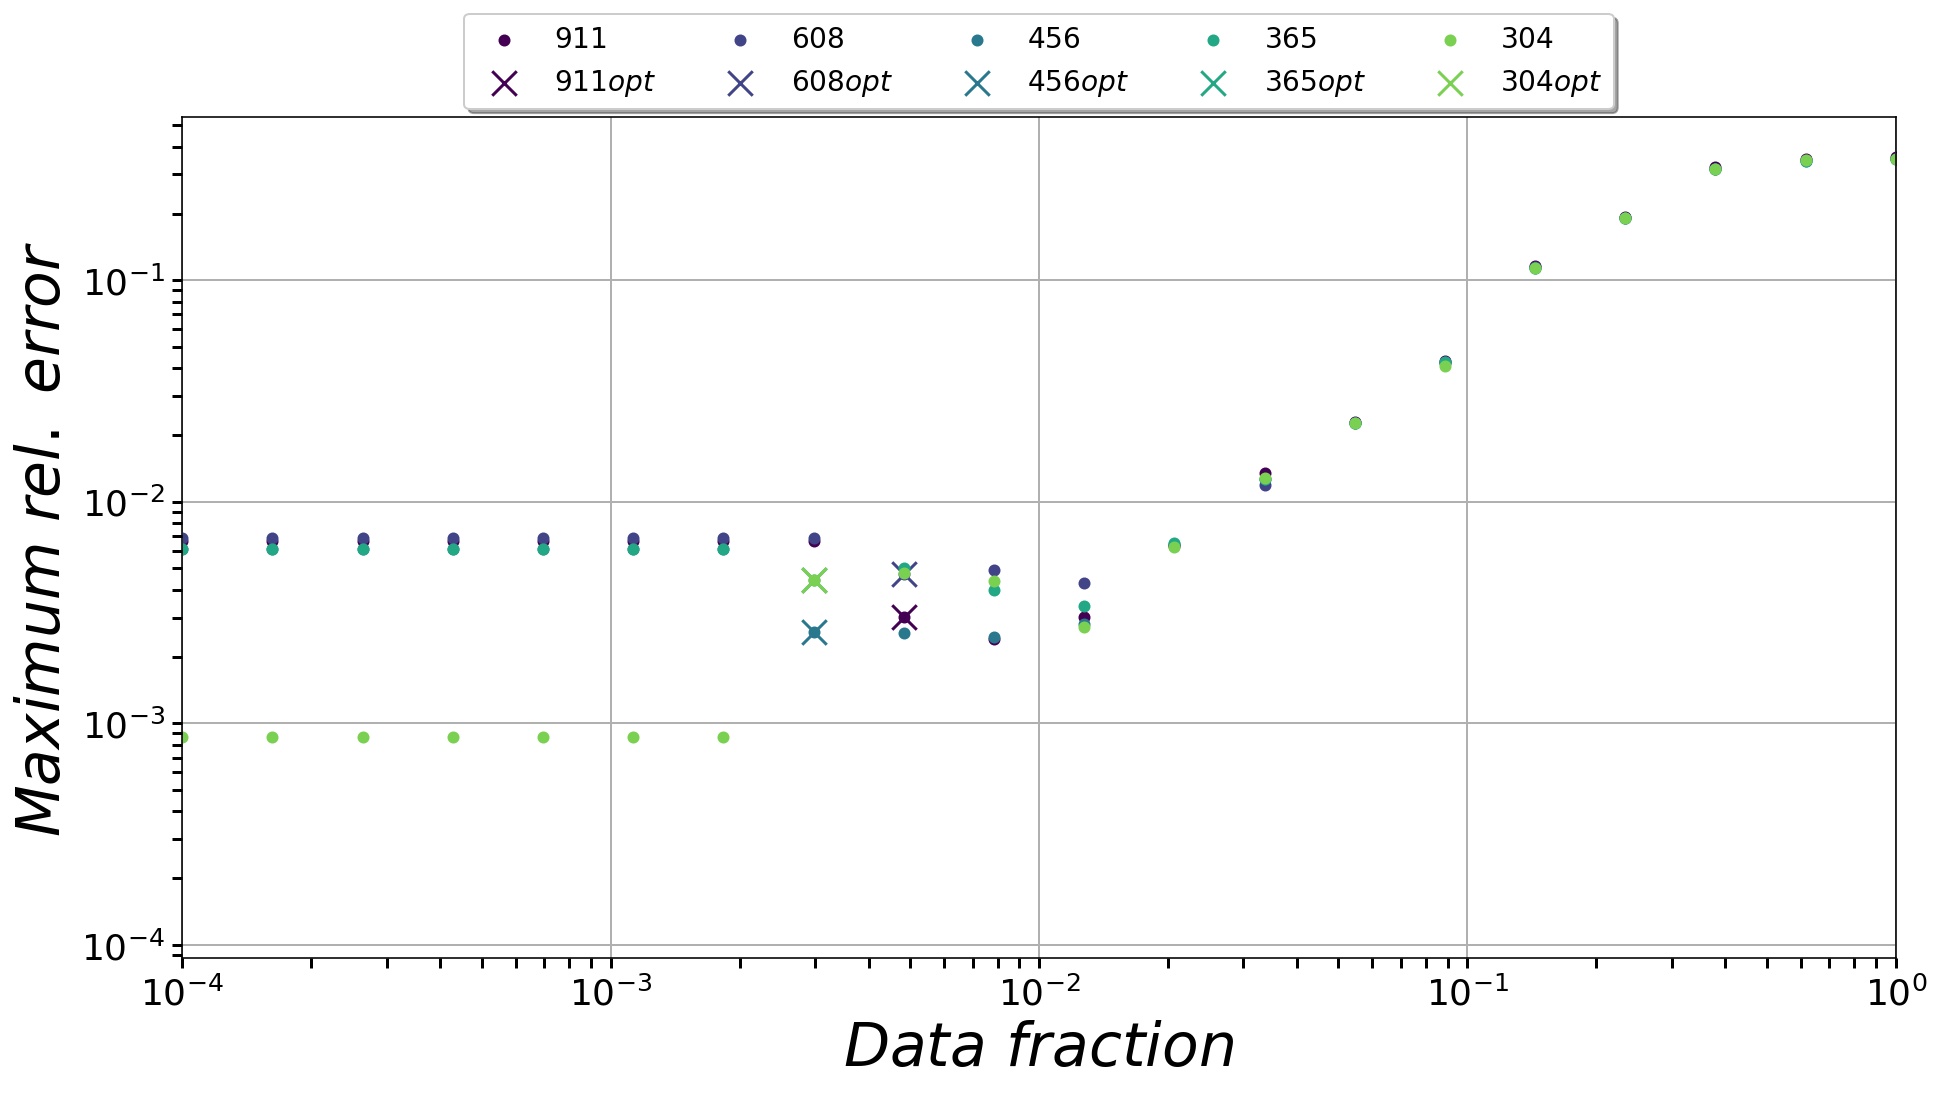

In [13]:
cNorm=matplotlib.colors.Normalize(vmin=0,vmax=noTests)
scalarMap=matplotlib.cm.ScalarMappable(norm=cNorm,cmap=cm)

fig,ax=matplotlib.pyplot.subplots(1,1,figsize=(14,8))
for testI in range(noTests):
    ax.scatter(fs,errsMax[0,:,testI],c=scalarMap.to_rgba(testI),s=25,
               marker='o',label=r'${:3.0f}$'.format(noTestPoints[testI]))
    ax.scatter(testMinFs[testI],testMinMaxErrs[testI],c=scalarMap.to_rgba(testI),
               s=150,marker='x',label=r'${:3.0f}opt$'.format(noTestPoints[testI]))
ax.set_xlabel(r"$Data\ fraction$",fontsize=labelsFontSize)
ax.set_ylabel(r"$Maximum\ rel.\ error$",fontsize=labelsFontSize)
ax.grid(linewidth=1)
ax.tick_params(axis='both',reset=False,which='both',length=5,width=1.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(fsT.min(),fsT.max())
matplotlib.pyplot.subplots_adjust(left=0.1,right=0.95,bottom=0.15,top=0.88)
ax.legend(bbox_to_anchor=(0.5,1.14),loc='upper center',
          prop={'size':legendFontSize},fancybox=True,shadow=True,ncol=noTests)
fig.show()

## 2-norms of differences between training & test subsets

This is what we actually optimised, so the `x`es are the optimiser solutions.

/home/alek/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


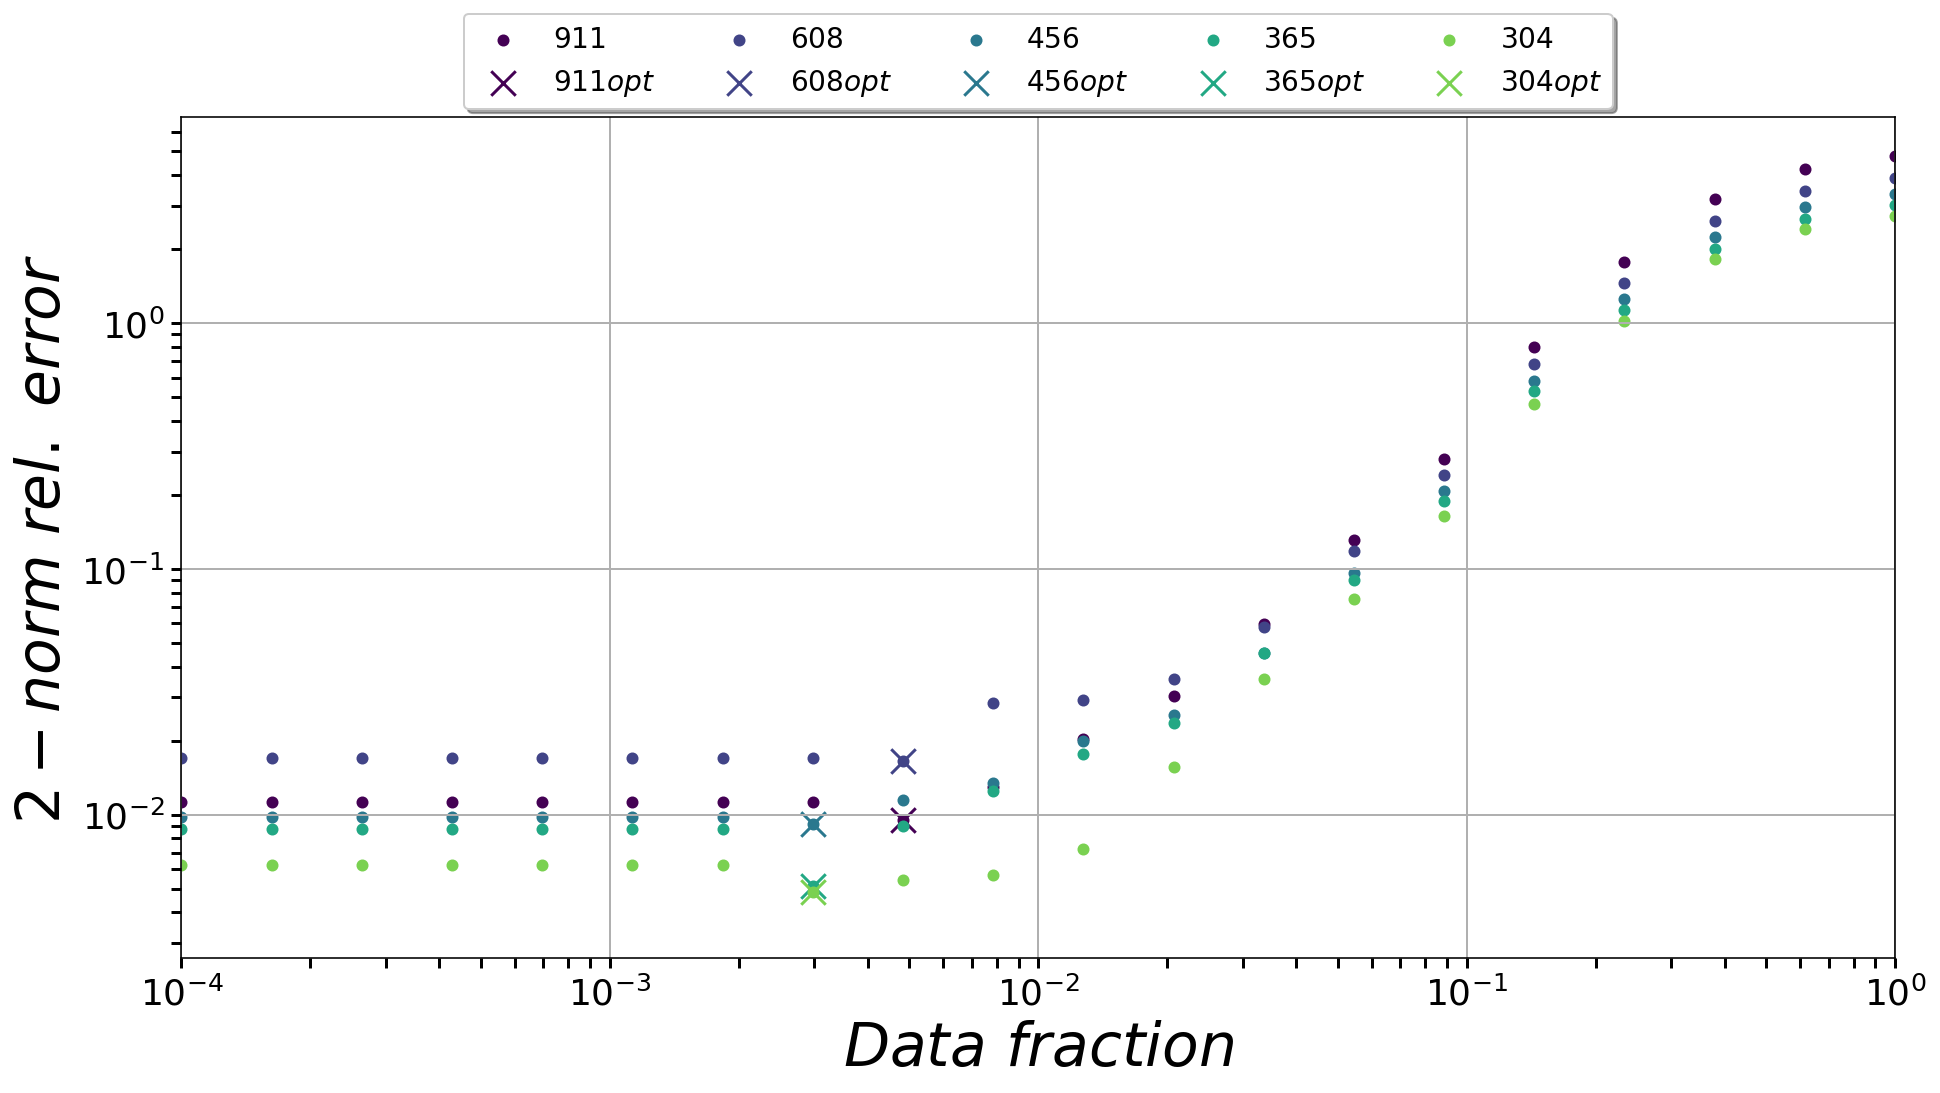

In [14]:
fig,ax=matplotlib.pyplot.subplots(1,1,figsize=(14,8))
for testI in range(noTests):
    ax.scatter(fs,errsNorm[0,:,testI],c=scalarMap.to_rgba(testI),s=25,
               marker='o',label=r'${:3.0f}$'.format(noTestPoints[testI]))
    ax.scatter(testMinFs[testI],testMin2Norms[testI],c=scalarMap.to_rgba(testI),
               s=150,marker='x',label=r'${:3.0f}opt$'.format(noTestPoints[testI]))
ax.set_xlabel(r"$Data\ fraction$",fontsize=labelsFontSize)
ax.set_ylabel(r"$2-norm\ rel.\ error$",fontsize=labelsFontSize)
ax.grid(linewidth=1)
ax.tick_params(axis='both',reset=False,which='both',length=5,width=1.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(fsT.min(),fsT.max())
matplotlib.pyplot.subplots_adjust(left=0.1,right=0.95,bottom=0.15,top=0.88)
ax.legend(bbox_to_anchor=(0.5,1.14),loc='upper center',
          prop={'size':legendFontSize},fancybox=True,shadow=True,ncol=noTests)
fig.show()

## 2nd derivatives of the smoothed time series

/home/alek/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


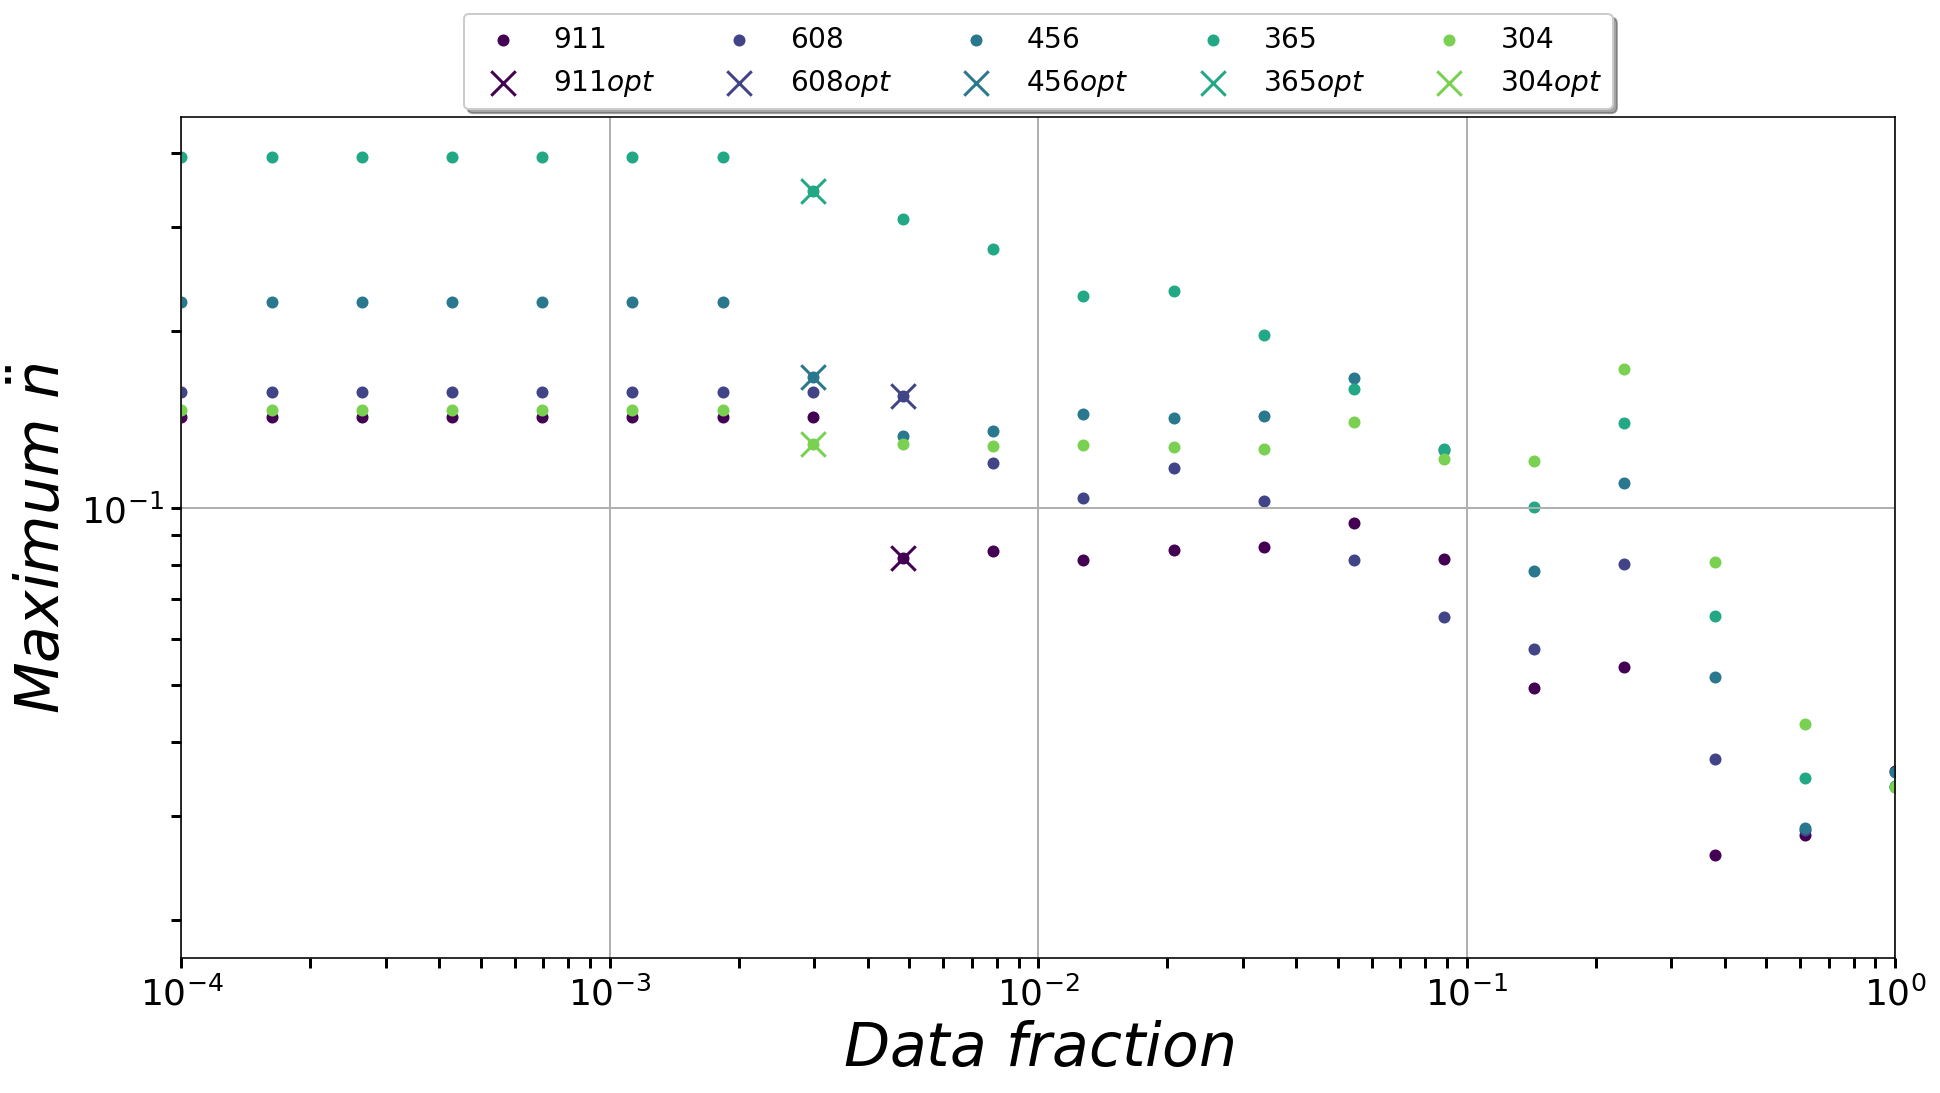

In [15]:
fig,ax=matplotlib.pyplot.subplots(1,1,figsize=(14,8))
for testI in range(noTests):
    ax.scatter(fs,secondMax[0,:,testI],c=scalarMap.to_rgba(testI),s=25,
               marker='o',label=r'${:3.0f}$'.format(noTestPoints[testI]))
    ax.scatter(testMinFs[testI],testMin2ndDer[testI],c=scalarMap.to_rgba(testI),
               s=150,marker='x',label=r'${:3.0f}opt$'.format(noTestPoints[testI]))
ax.set_xlabel(r"$Data\ fraction$",fontsize=labelsFontSize)
ax.set_ylabel(r"$Maximum\ \ddot{n}$",fontsize=labelsFontSize)
ax.grid(linewidth=1)
ax.tick_params(axis='both',reset=False,which='both',length=5,width=1.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(fsT.min(),fsT.max())
matplotlib.pyplot.subplots_adjust(left=0.1,right=0.95,bottom=0.15,top=0.88)
ax.legend(bbox_to_anchor=(0.5,1.14),loc='upper center',
          prop={'size':legendFontSize},fancybox=True,shadow=True,ncol=noTests)
fig.show()

## And the winner is

Check the spectrum of what the optimiser has found for different test cases (test and training subsets), as well as some statistics.

In [16]:
print("Optimum f from {:.4e} to {:.4e}, mean={:.4e}, median={:.4e}".format(
      testMinFs.min(),testMinFs.max(),testMinFs.mean(),numpy.median(testMinFs)))

Optimum f from 2.9764e-03 to 4.8329e-03, mean=3.7190e-03, median=2.9764e-03
